In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from Functions import Metrics

In [2]:
df = pd.read_csv('Hotel_Reservations_clean.csv')
df.head(3)

,index,Booking_ID,num_adults,num_children,weekend_nights,week_nights,total_nights,meal_plan,car_parking,room_type,...,num_prev_cancellations,num_prev_not_canceled,avg_price_room,num_sp_requests,booking_status,meal_plan_cod,room_type_cod,mkt_segment_cod,arrival_season_cod,booking_status_cod
0,0,INN00001,2,0,1,2,3,Meal Plan 1,0,Room_Type 1,...,0,0,65.00,0,No cancelada,1,1,3,3,0
1,1,INN00002,2,0,2,3,5,Not Selected,0,Room_Type 1,...,0,0,106.68,1,No cancelada,0,1,4,1,0
2,2,INN00003,1,0,2,1,3,Meal Plan 1,0,Room_Type 1,...,0,0,60.00,0,Cancelada,1,1,4,1,1


## Modelado

### Pre-Procesamiento

#### Codificacion de variables cualitativas

In [3]:
var_dummy = pd.get_dummies(df.mkt_segment, dtype=int)
var_dummy.head(3)

,Aviation,Complementary,Corporate,Offline,Online
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1


### Feature engineering

In [4]:
#SE ESTANDARIZAN VARIABLES (µ=0; σ=1)
scaler = StandardScaler()
date_vars = scaler.fit_transform(df[['arrival_day', 'arrival_month']])

#REDUCCION DE DIMENSIONALIDAD
pca = PCA(n_components=1)
reduce_vars = pca.fit_transform(date_vars)
reduce_vars = pd.Series(reduce_vars.flatten(), name='reduce_var')

#RESULTADO
print(f'Varianza explicada por la variable reducida: {pca.explained_variance_ratio_}')

Varianza explicada por la variable reducida: [0.52167988]


In [5]:
#SE ESTANDARIZAN VARIABLES (µ=0; σ=1)
std_vars = pd.DataFrame(StandardScaler().fit_transform(df[['lead_time', 'avg_price_room']]),
                        columns=['lead_time', 'avg_price_room'])

#RESULTADO
std_vars.head(3)

,lead_time,avg_price_room
0,1.615007,-1.369842
1,-0.932939,0.130451
2,-0.979477,-1.549819


In [6]:
#SELECCION DE VARIABLES PARA EL ENTRENAMIENTO
vars = ['num_sp_requests','car_parking', 'meal_plan_cod', 'num_adults',
        'num_children','weekend_nights', 'week_nights','room_type_cod']

x = pd.concat([df[vars], std_vars, reduce_vars,var_dummy], axis=1)

y = df.booking_status_cod

### Entrenamiento, validacion y métricas

#### Entrenamiento y validacion simple

In [7]:
#SPLIT DE LOS DATOS PARA ENTRENAR Y VALIDAR
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=42)

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = RandomForestClassifier(max_depth=18, max_features=0.5, n_estimators=300, random_state=42)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)

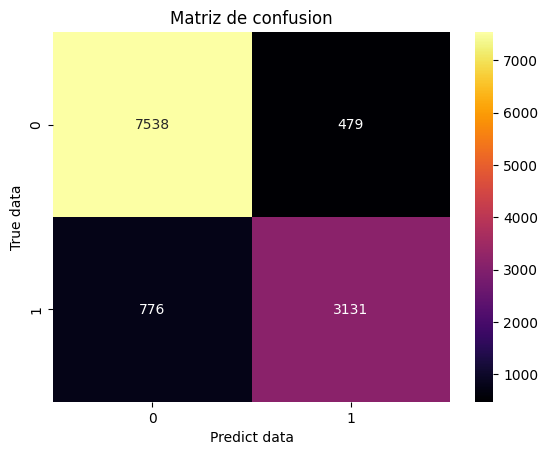

In [10]:
#GRAFICO DE MATRIZ DE CONFUSION
Metrics().plot_matrix_confusion(y_test, y_pred)

In [11]:
#REPORTE DE METRICAS
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      8017
           1       0.87      0.80      0.83      3907

    accuracy                           0.89     11924
   macro avg       0.89      0.87      0.88     11924
weighted avg       0.89      0.89      0.89     11924



In [12]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob)}')

Score curva ROC: 0.9501210299242852


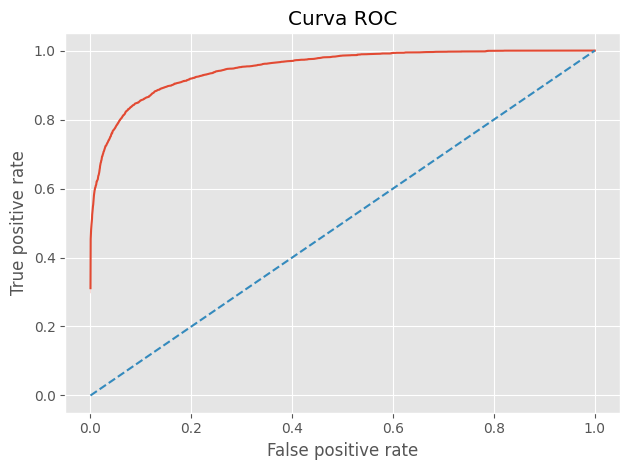

In [13]:
#GRAFICO CURVA ROC
Metrics.plot_roc_curve(y_test, y_prob)

#### Entrenamiento y validacion cruzada

In [14]:
#IMPORTACION DE HERRAMIENTA
from sklearn.model_selection import StratifiedKFold

#SE INSTANCIA MODELO DE VALIDACION CRUZADA
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#DIVICION DE DE DATOS PARA ITERACIONES
train_test = list(skf.split(x,y))

In [15]:
#LISTA PARA GUARDAR METRICAS
accuracies = []

#EJECUCION DE LA LOGICA DE MODELO
for k in range(skf.get_n_splits(x,y)):
    #Separacion de datos para train y test
    train, test = train_test[k]
    X_train, y_train, X_test, y_test = x.iloc[train], y.iloc[train], x.iloc[test], y.iloc[test]

    #Entrenamiento y prediccion
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Guardado de resultados
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Accuracy iteracion {k+1}: {accuracy:.4f}')

#PROMEDIO DE ACCURACY
print(f'Accuracy promedio: {np.array(accuracies).mean():.4f}')

Accuracy iteracion 1: 0.8932
Accuracy iteracion 2: 0.8922
Accuracy iteracion 3: 0.8901
Accuracy iteracion 4: 0.8963
Accuracy iteracion 5: 0.8961
Accuracy promedio: 0.8936


### Mejora con boosting

#### Entrenamiento y metricas XG-Boosting

In [16]:
#SEPARACION DE DATOS PARA TRAIN Y TEST
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=42)

#GRILLA DE PARAMETROS PARA TESTEAR
param_grid = {
    'objective' :['binary:logistic'],
    'max_depth': [10, 15],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [9, 15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0.1, 0.2],
    'random_state': [47]
}

In [20]:
#IMPORTACION DE MODELOS
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

#SE ENTRENA MODELO UTILIZANDO GRIDSEARCH
model = GridSearchCV(estimator=XGBClassifier(),
                     param_grid=param_grid,
                     cv=3, n_jobs=-1,
                     scoring='accuracy')

#ENTRENAMIENTO
model.fit(X_train,y_train)

#MEJORES PARAMETROS ENCONTRADOS
print('Mejores Hyper-Parametros:')
for key, value in model.best_params_.items():
    print(f'\t{key}: {value}')

#PREDICCION
y_pred = model.predict(X_test)

Mejores Hyper-Parametros:
	colsample_bytree: 0.8
	gamma: 0.1
	learning_rate: 0.2
	max_depth: 15
	n_estimators: 15
	objective: binary:logistic
	random_state: 47
	subsample: 0.8


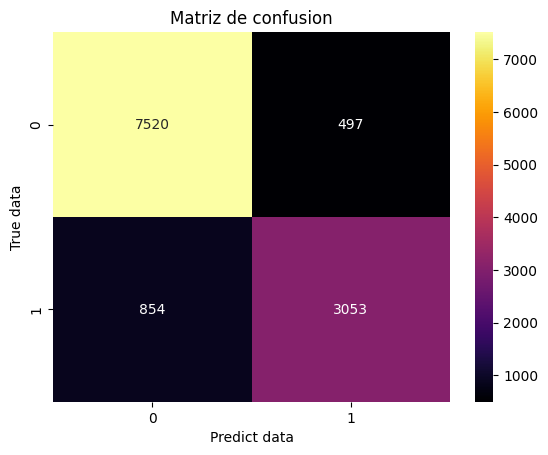

In [30]:
#GRAFICO MATRIZ DE CONFUSION
Metrics().plot_matrix_confusion(y_test, y_pred)

In [24]:
#REPORTE DE METRICAS
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      8017
           1       0.86      0.78      0.82      3907

    accuracy                           0.89     11924
   macro avg       0.88      0.86      0.87     11924
weighted avg       0.89      0.89      0.89     11924



In [25]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob)}')

Score curva ROC: 0.944973933845914


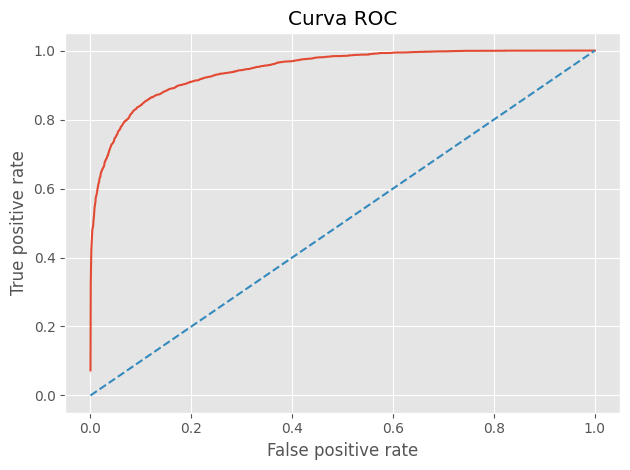

In [28]:
#GRAFICO CURVA ROC
Metrics.plot_roc_curve(y_test, y_prob)

#### Entrenamiento y validacion cruzada

In [18]:
#LISTA PARA GUARDAR METRICAS
accuracies = []

#EJECUCION DE LA LOGICA DE MODELO
for k in range(skf.get_n_splits(x,y)):
    #Separacion de datos para train y test
    train, test = train_test[k]
    X_train, y_train, X_test, y_test = x.iloc[train], y.iloc[train], x.iloc[test], y.iloc[test]

    #Entrenamiento y prediccion
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Guardado de resultados
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Accuracy iteracion {k+1}: {accuracy:.4f}')

#PROMEDIO DE ACCURACY
print(f'Accuracy promedio: {np.array(accuracies).mean():.4f}')


Accuracy iteracion 1: 0.8857
Accuracy iteracion 2: 0.8868
Accuracy iteracion 3: 0.8858
Accuracy iteracion 4: 0.8867
Accuracy iteracion 5: 0.8832
Accuracy promedio: 0.8856
